In [22]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

In [23]:
import tensorflow as tf
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator

# Creating Generators

In [24]:
# Define image dimensions
img_width, img_height = 224, 224

# Define number of classes
num_classes = 8

# Define batch size
batch_size = 32

# Define number of epochs
epochs = 10

# Define paths to training and validation data
train_data_dir = 'data/train.csv'
test_data_dir = 'data/test.csv'

train_df = pd.read_csv(train_data_dir)
test_df = pd.read_csv(test_data_dir)

# cast the labels to categorical
train_df = train_df.astype({'label': 'string'})
test_df = test_df.astype({'label': 'string'})

# Data preprocessing and augmentation
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input        
)

train_images = train_generator.flow_from_dataframe(train_df,
                                                    x_col='path_img',
                                                    y_col='label',
                                                    target_size=(img_width, img_height),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle = True,
                                                    seed = 42,
                                                    subset = 'training')

val_images = train_generator.flow_from_dataframe(train_df,
                                                        x_col='path_img',
                                                        y_col='label',
                                                        target_size=(img_width, img_height),
                                                        color_mode='rgb',
                                                        class_mode='categorical', 
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        seed=42,
                                                        subset='validation')

test_images = test_generator.flow_from_dataframe(test_df,
                                                        x_col='path_img',
                                                        y_col='label',
                                                        target_size=(img_width, img_height),
                                                        color_mode='rgb',
                                                        class_mode='categorical',
                                                        batch_size=batch_size,
                                                        shuffle=False)

Found 8952 validated image filenames belonging to 8 classes.
Found 2238 validated image filenames belonging to 8 classes.
Found 4797 validated image filenames belonging to 8 classes.


/home/22021108Cristina/.local/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 10 invalid image filename(s) in x_col="path_img". These filename(s) will be ignored.
  warnings.warn(
/home/22021108Cristina/.local/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 10 invalid image filename(s) in x_col="path_img". These filename(s) will be ignored.
  warnings.warn(
/home/22021108Cristina/.local/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="path_img". These filename(s) will be ignored.
  warnings.warn(


# MODELING

In [25]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_width, img_height, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [26]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

# TRAINING

In [27]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data= val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
229/280 [=======================>......] - ETA: 6s - loss: 0.6686 - accuracy: 0.7819

/home/22021108Cristina/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


280/280 [==============================] - 47s 164ms/step - loss: 0.6531 - accuracy: 0.7880 - val_loss: 0.4643 - val_accuracy: 0.8552
Epoch 2/100
280/280 [==============================] - 43s 154ms/step - loss: 0.3833 - accuracy: 0.8778 - val_loss: 0.4494 - val_accuracy: 0.8561
Epoch 3/100
280/280 [==============================] - 41s 148ms/step - loss: 0.2907 - accuracy: 0.9054 - val_loss: 0.4290 - val_accuracy: 0.8749
Epoch 4/100
280/280 [==============================] - 41s 147ms/step - loss: 0.2237 - accuracy: 0.9281 - val_loss: 0.4365 - val_accuracy: 0.8709
Epoch 5/100
280/280 [==============================] - 42s 151ms/step - loss: 0.1594 - accuracy: 0.9507 - val_loss: 0.5277 - val_accuracy: 0.8570
Epoch 6/100
280/280 [==============================] - 42s 149ms/step - loss: 0.1153 - accuracy: 0.9631 - val_loss: 0.5344 - val_accuracy: 0.8651


In [35]:
# save the model
model.save('models/content/2.1_0-CNN_TL-Res.h5')

# RESULTS


In [30]:
from sklearn.metrics import confusion_matrix, classification_report

In [31]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/home/22021108Cristina/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Accuracy: 86.35%


In [32]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

150/150 [==============================] - 30s 196ms/step


ValueError: The number of FixedLocator locations (101), usually from a call to set_ticks, does not match the number of labels (8).

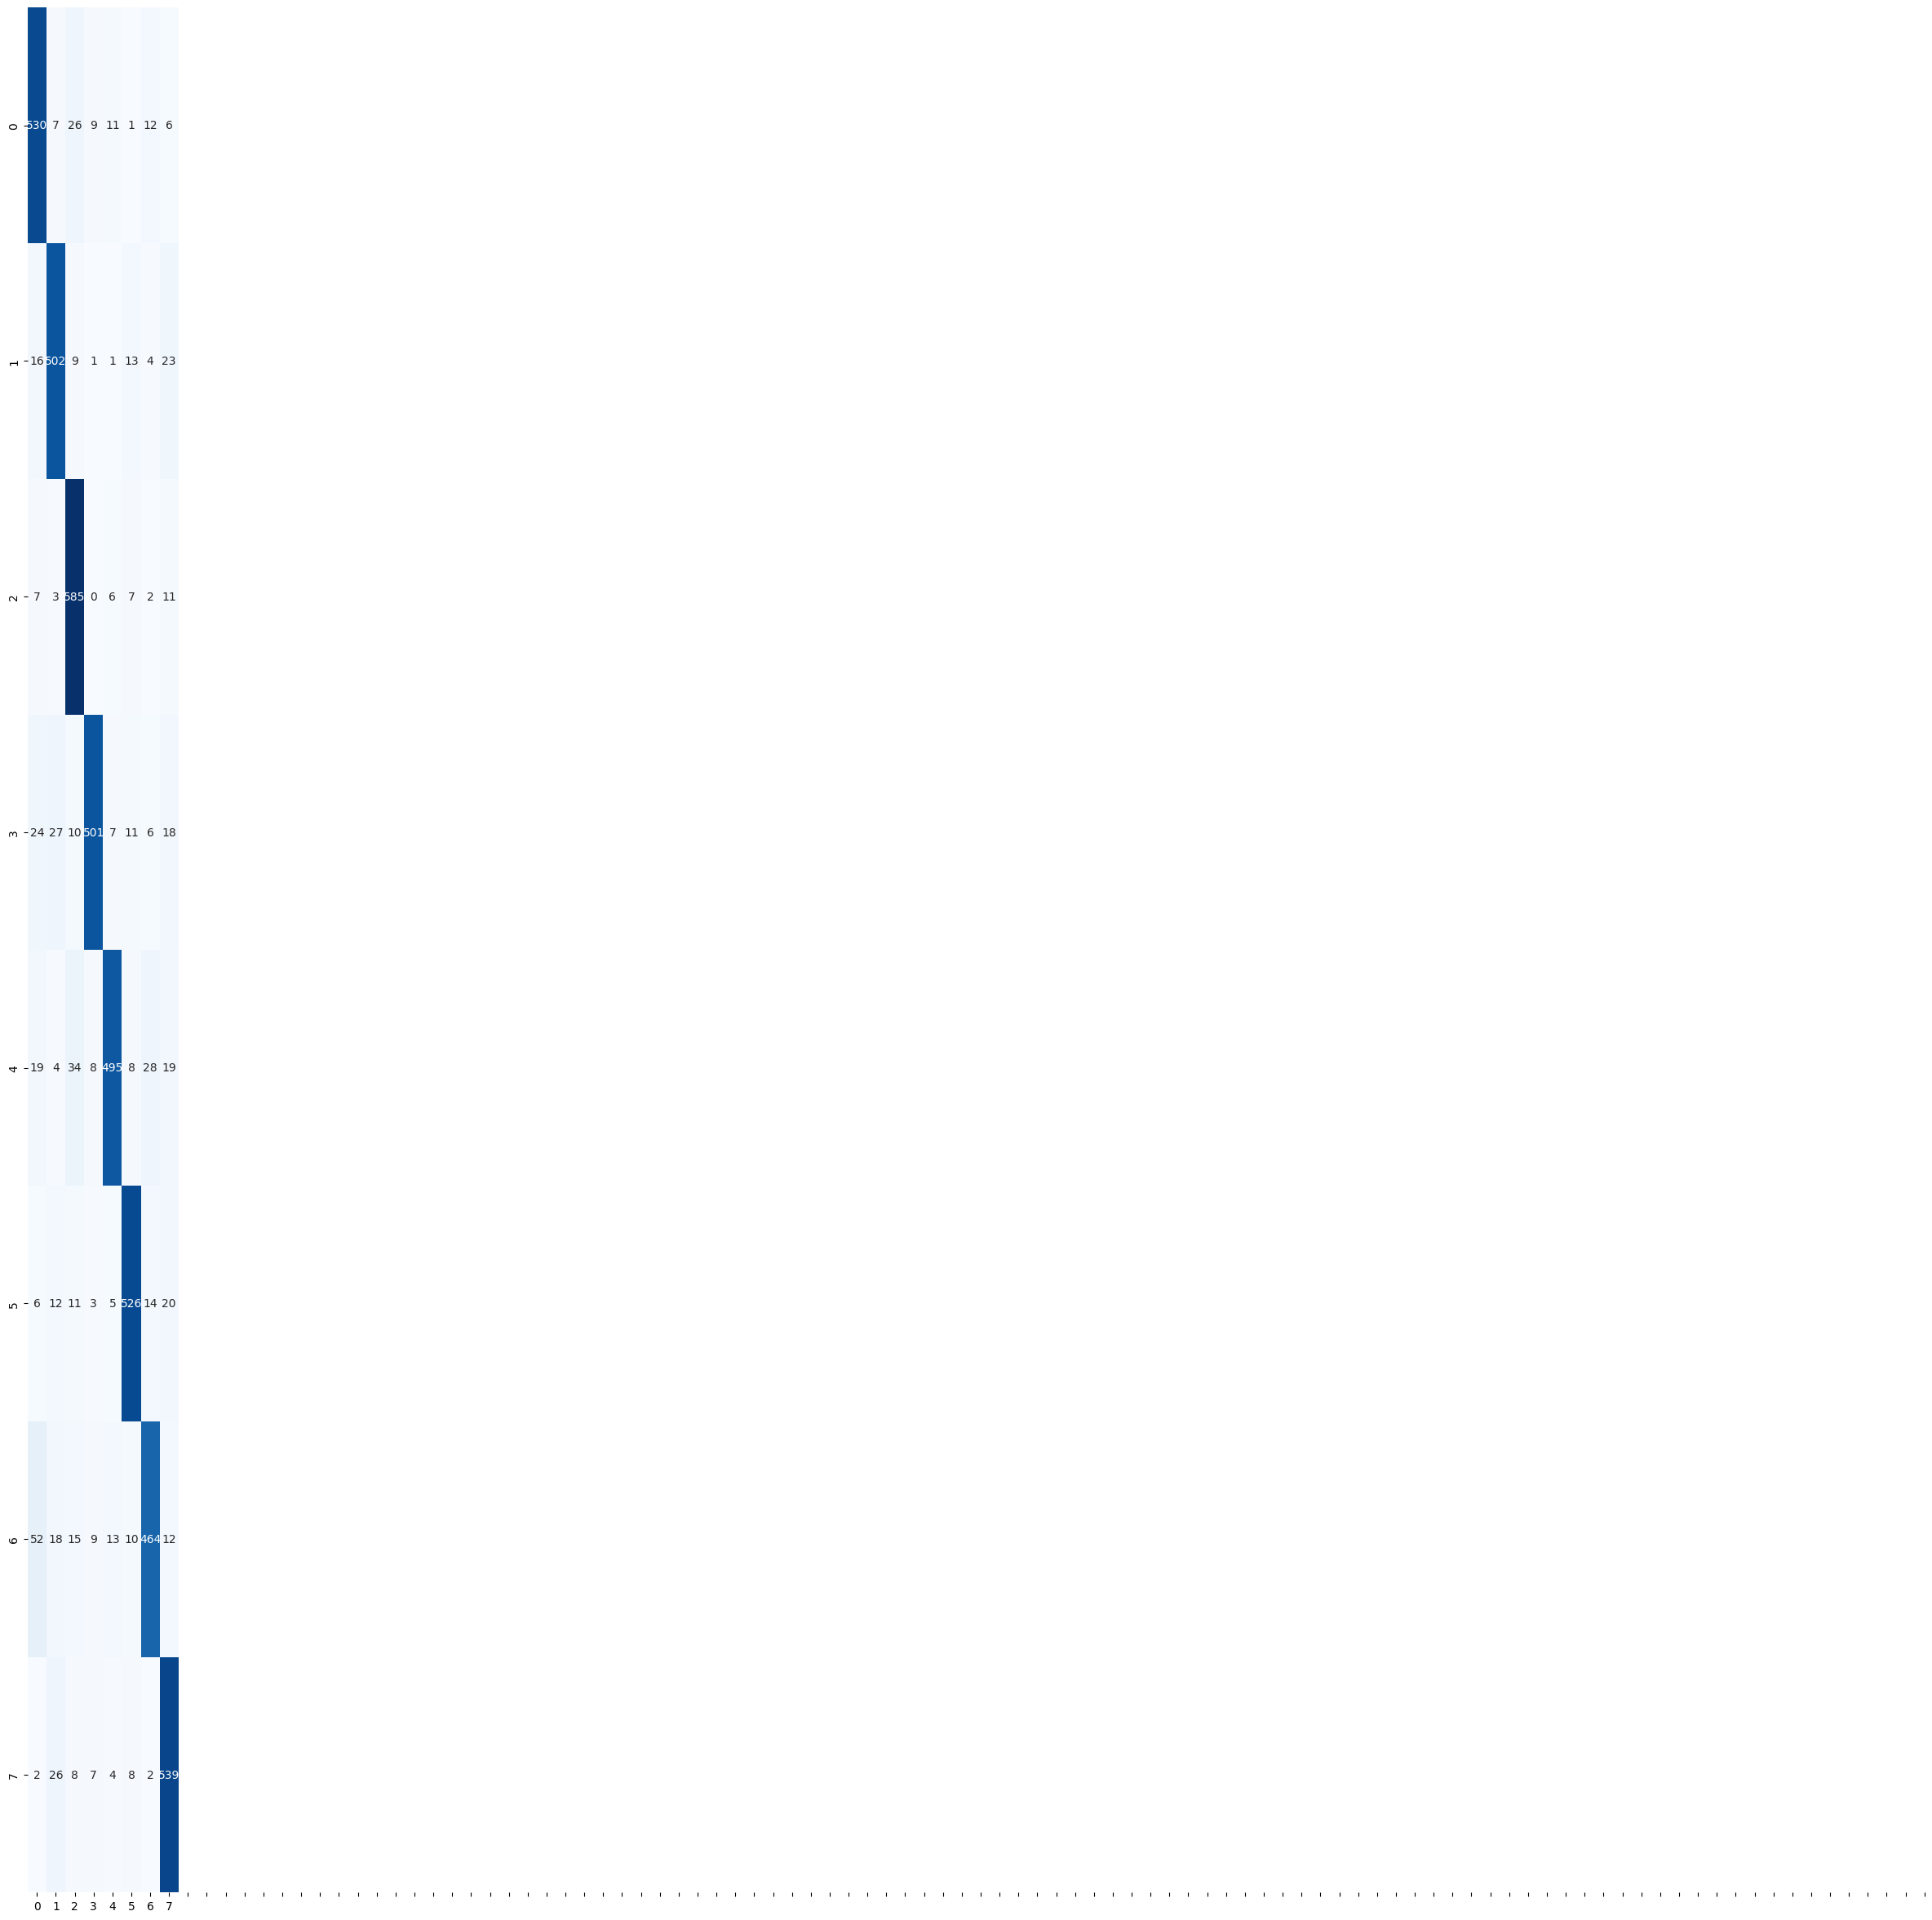

In [33]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [34]:
print("Classification Report:\n----------------------\n", clr)


Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       602
           1       0.84      0.88      0.86       569
           2       0.84      0.94      0.89       621
           3       0.93      0.83      0.88       604
           4       0.91      0.80      0.86       615
           5       0.90      0.88      0.89       597
           6       0.87      0.78      0.82       593
           7       0.83      0.90      0.87       596

    accuracy                           0.86      4797
   macro avg       0.87      0.86      0.86      4797
weighted avg       0.87      0.86      0.86      4797

